In [2]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

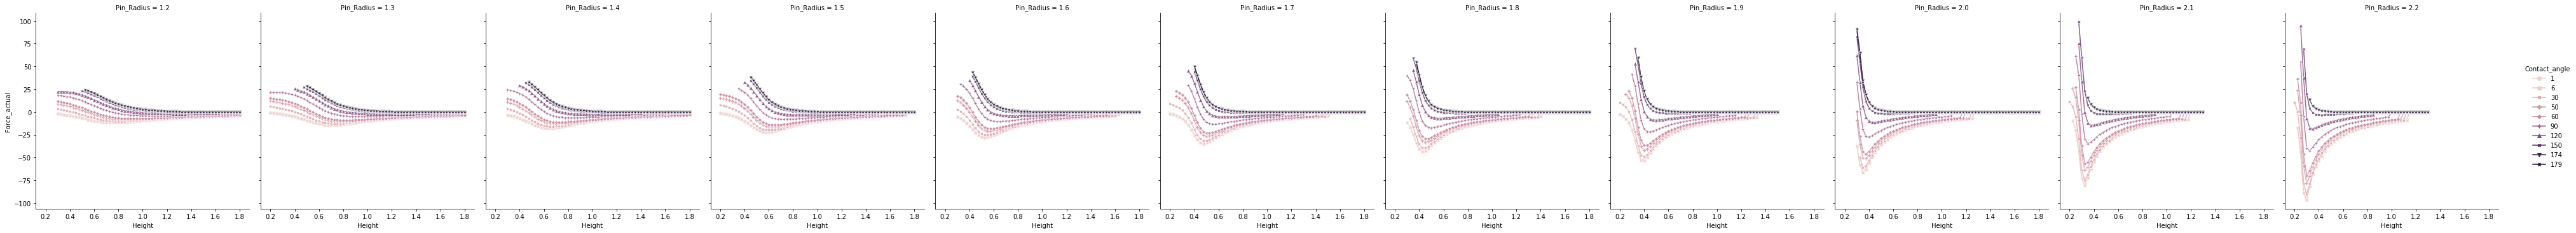

In [3]:
folderpath = 'E:/Work/Surface Evolver/Data/Bubble_Bridge/20210716 model data all/'
simu_df = pd.DataFrame()
with os.scandir(folderpath) as folder_main:    
    for subfolder in folder_main:
        if subfolder.is_dir():            
            simu_folderpath = subfolder.path
            with os.scandir(simu_folderpath) as folder:
                rupture_path = simu_folderpath + '/rupture.txt'
                df_rupture = pd.read_csv(rupture_path,delimiter='\t')
                for file in folder:
                    if file.is_file() and file.path.endswith( ('.txt') ) and file.name != 'rupture.txt':
                        df_temp = pd.read_csv(file.path,delimiter='\t')
                        height_range = df_rupture[df_rupture['Angle'] == df_temp['Bottom_Angle'].iloc[0]]
                        rupture_height = height_range['Rupture_Height'].iloc[0]
                        start_height = height_range['Start_Height'].iloc[0]
                        df_temp['Force_corrected1'] = np.where(df_temp['Height'] > rupture_height, 
                                                              0, df_temp['Force_Calc'])
                        df_temp['Force_corrected2'] = np.where(df_temp['Height'] < start_height, 
                                                              np.nan, df_temp['Force_corrected1'])
                        df_temp['Bottom_Area_corrected'] = np.where(df_temp['Height'] > rupture_height, 
                                                              0, df_temp['Bottom_Area'])
                        #df_temp['ys/F'] = -1/(2*np.pi*df_temp['Force_Calc']) #inverse
                        df_temp['File path'] = file.path
                        simu_df = simu_df.append(df_temp)

simu_df['Simulation folder'] = simu_folderpath
simu_df['Force_actual'] = simu_df['Force_corrected2']*2*np.pi
simu_df['Contact_angle'] = 180 - simu_df['Bottom_Angle']
simu_df.dropna(inplace=True)
simu_df.reset_index(inplace=True)
#simul_plot(simu_df)

sns.relplot(data=simu_df,
            x = "Height",
            y = "Force_actual",
            hue = "Contact_angle",
            style = "Contact_angle",
            col = 'Pin_Radius',
            kind = 'line',
            sort = False,
            markers = True,
            dashes = False,
            alpha = 0.8,
            legend = 'full',
            facet_kws={"legend_out": True})
plt.show()

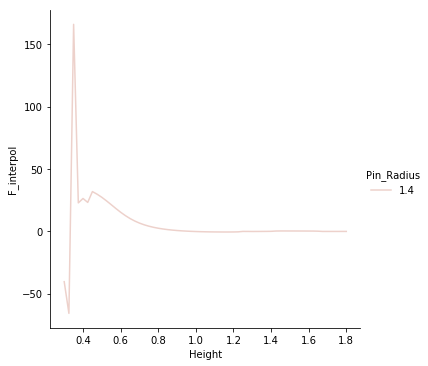

In [4]:
#compute force-distance curve for arbitrary contact angle
def get_fd(simu_df, contact_angle):
    
    df_ca = pd.DataFrame()
    for pin_radius in simu_df['Pin_Radius'].unique():
        F_fit = []
        A_fit = [] #bottom contact area
        h_range = []
        simu_df_pr = simu_df[simu_df['Pin_Radius'] == pin_radius]
        for h in simu_df_pr['Height'].unique():
            simu_df_h = simu_df_pr[simu_df_pr['Height'] == h]
            simu_df_h = simu_df_h.sort_values(by=['Contact_angle'])
            #5th order polynomial fit of Force-Contact angle data
            fh_fit = np.polyfit(simu_df_h['Contact_angle'], simu_df_h['Force_actual'], 5)
            F_fit.append(np.polyval(fh_fit,contact_angle))
            ah_fit = np.polyfit(simu_df_h['Contact_angle'], simu_df_h['Bottom_Area_corrected'], 5)
            A_fit.append(np.polyval(ah_fit,contact_angle))
            h_range.append(h)
        df_ca_temp = pd.DataFrame({'Height': h_range,
                                   'F_interpol': F_fit,
                                   'A_interpol': A_fit})
        df_ca_temp['Pin_Radius'] = pin_radius
        df_ca = df_ca.append(df_ca_temp)
    
    return df_ca

df = get_fd(simu_df, 150)
sns.relplot(data=df[df['Pin_Radius']==1.4],
            x = "Height",
            y = "F_interpol",
            hue = "Pin_Radius",
            kind = 'line')
plt.show()

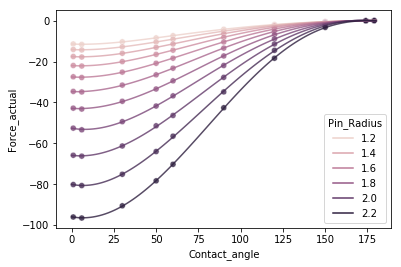

In [5]:
#get adhesion data and fit

group_vars = ['Contact_angle', 'Pin_Radius', 'Elastic_Modulus', 'Aspect_Ratio',
              'Ambient_Pressure']
simu_adh_df = simu_df.loc[simu_df.groupby(group_vars)["Force_actual"].idxmin()]

contact_angle_range = np.linspace(0,180,100)
df_fit = pd.DataFrame()
fit_dict = {} #Fit equation dictionary. pin_radius: [force-fit, height-fit] equations

for pin_radius in simu_adh_df['Pin_Radius'].unique():
    df_temp = simu_adh_df[simu_adh_df['Pin_Radius'] == pin_radius]
    #5th order polynomial fit of Force-Contact angle data
    fr_fit = np.polyfit(df_temp['Contact_angle'], df_temp['Force_actual'], 5)  
    fh_fit = np.polyfit(df_temp['Contact_angle'], df_temp['Height'], 5)  
    force_fit = np.polyval(fr_fit,contact_angle_range)
    df_fit_temp = pd.DataFrame({'Contact_angle': contact_angle_range,
                         'Force_fit': force_fit})
    df_fit_temp['Pin_Radius'] = pin_radius
    df_fit = df_fit.append(df_fit_temp)
    fit_dict[pin_radius] = [fr_fit, fh_fit]

fig, ax = plt.subplots()
sns.scatterplot(data=simu_adh_df,
            x = "Contact_angle",
            y = "Force_actual",
            hue = 'Pin_Radius',
            alpha = 0.8,
            ax = ax, 
            legend = False)

sns.lineplot(data=df_fit,
            x = "Contact_angle",
            y = "Force_fit",
            hue = 'Pin_Radius',
            alpha = 0.8,
            ax = ax)

plt.show()

In [6]:
#capillary bridge model: force-distance curves

def get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa, 
                 theta_fa, theta_wa, phi_f, phi_b, s_f):
    cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
    cos_fw = -1 if cos_fw <-1 else cos_fw
    cos_fw = 1 if cos_fw >1 else cos_fw
    theta_fw = np.arccos(cos_fw)*180/np.pi 


    N = alpha*(Dp_Dh**2)
    print(theta_fw, N)
    s_b = (phi_f/phi_b)*Dp_Dh*s_f #bubble size scale Vb = 4/3*pi*s_b^3
    
    #in air
    df_a = get_fd(simu_df, theta_fa)
    df_a = df_a[df_a['Pin_Radius']==phi_f]
    df_a['Force'] = df_a['F_interpol']*y_fa*s_f*N
    df_a['Height_actual'] = df_a['Height']*s_f
    
    #underwater
    df_w = get_fd(simu_df, theta_fw)
    df_w = df_w[df_w['Pin_Radius']==phi_f]
    df_w['Force'] = df_w['F_interpol']*y_fw*s_f*N
    df_w['Height_actual'] = df_w['Height']*s_f
    
    #bubble's contribution
    df_b = get_fd(simu_df, 180-theta_wa)
    df_b = df_b[df_b['Pin_Radius']==phi_b]
    df_b['Force'] = df_b['F_interpol']*y_wa*s_b
    df_b['Height_actual'] = df_b['Height']*s_b
    df_b['Area_actual'] = df_b['A_interpol']*s_b*s_b
    
    h_bubble = df_a['Height_actual'] + (2*phi_f*s_f*asp_ratio)
    h_bubble_range = [min(h_bubble), max(h_bubble)]
    bubble_actual = df_b[(df_b['Height_actual'] >= h_bubble_range[0]) & 
                        (df_b['Height_actual'] <= h_bubble_range[1])].iloc[0]
    force_bubble = bubble_actual['Force']
    area_bubble = bubble_actual['Area_actual']
    area_pad = np.pi*0.25*(Dp_Dh*2*phi_f*s_f)**2
    #area fraction to get hairs inside and outside the bubble
    area_fraction_inside = area_bubble/area_pad if area_bubble < area_pad else 1
    
    df_all = pd.merge(df_a, df_w, how='left', on='Height_actual',
                        suffixes = ['_air', '_water'])
    df_all['Force_with_bubble'] = area_fraction_inside*df_all['Force_air'] + \
                                    (1-area_fraction_inside)*df_all['Force_water'] + force_bubble
    df_all['Force_bubble_only'] = force_bubble
    df_all['Area_fraction_inside'] = area_fraction_inside

    return df_all

In [52]:
#ladybug's parameter values
N_h = 500 #number of hairs
D_h = 4e-6 #hair diameter (m)
D_p = 200e-6 #pad diameter (m)
L_h = 40e-6 #hair length (m)
y_fa = 27e-3 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 55e-3 #fluid-water interfacial tension (N/m)
y_wa = 72e-3 #water surface tension (N/m)
V_f = 4e-18 #fluid volume (m^3)
V_b = 1e-12 #bubble volume (m^3)

#convert to model parameters
s_f = (3*V_f/(4*np.pi))**(1/3) #s_f
s_b = (3*V_b/(4*np.pi))**(1/3) #s_b
phi_f = round(D_h/(2*s_f),1) #D_h/2s_f
phi_b = round(D_p/(2*s_b),1) #D_p/2s_b
Dp_Dh = D_p/D_h
alpha = N_h/(Dp_Dh**2)
asp_ratio = L_h/D_h
print('Dp_Dh:', Dp_Dh, 'alpha:', alpha, 'asp_ratio:', asp_ratio, 
      'y_fa:', y_fa, 'y_fw:', y_fw, 'y_wa:', y_wa,
      'phi_f', phi_f, 'phi_b', phi_b, 's_f', s_f)

Dp_Dh: 50.00000000000001 alpha: 0.19999999999999993 asp_ratio: 10.000000000000002 y_fa: 0.027 y_fw: 0.055 y_wa: 0.072 phi_f 2.0 phi_b 1.6 s_f 9.847450218426974e-07


137.89550377387408 500.0
69.9386943715081 500.0


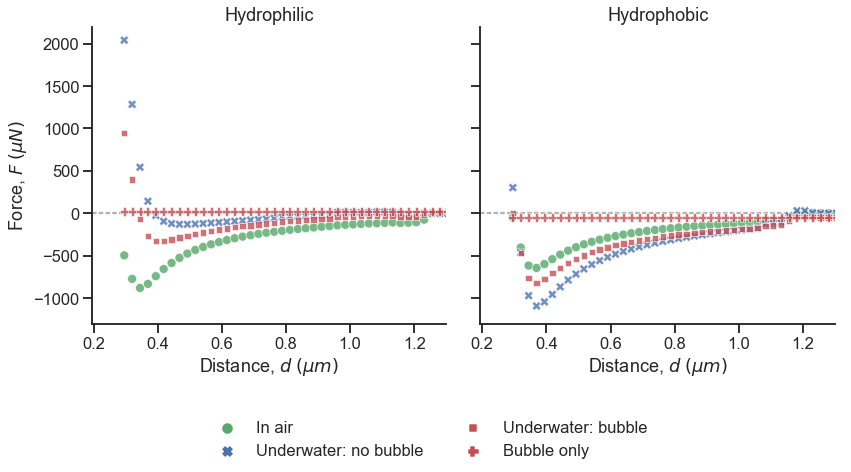

In [53]:
#Get model data 

# Dp_Dh = 50 #Dp/Dh
# alpha = 0.1
# asp_ratio = 10 #L/Dh

# y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
# y_fw = 2 #fluid-water interfacial tension (N/m)
# y_wa = 3 #water surface tension (N/m)
# phi_f = 2 #fluid size parameter
# phi_b = 1.6 #bubble size parameter

# s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air
df_phil = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                       theta_fa, theta_wa, phi_f, phi_b, s_f)
df_phil['Substrate'] = 'Hydrophilic'
df_phil['theta_fa'] = theta_fa
df_phil['theta_wa'] = theta_wa

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air
df_phob = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                       theta_fa, theta_wa, phi_f, phi_b, s_f)
df_phob['Substrate'] = 'Hydrophobic'
df_phob['theta_fa'] = theta_fa
df_phob['theta_wa'] = theta_wa

modelData = df_phil.append(df_phob)

# Clean data
modelData.rename(columns = {'Force_air': 'In air',
                            'Force_with_bubble': 'Underwater: bubble',
                            'Force_water': 'Underwater: no bubble',
                            'Force_bubble_only': 'Bubble only',
                            'Height_actual': 'Distance'},
                 inplace = True)
column_list = list(modelData.columns)

#forces to include in plot (used to convert data to long form)
force_order = ['In air','Underwater: no bubble','Underwater: bubble', 'Bubble only']


#reshape force data into long form based on force_vars
id_vars_list = [x for x in column_list if x not in force_order]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Model",
                        value_name="Force")


data_reshaped['Force'] = data_reshaped['Force']/1e-6 #uN
data_reshaped['Distance'] = data_reshaped['Distance']/1e-6 #um

# Configure plot style
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (12,6) #figure size

# Plot data
color_list = ['g', 'b', 'r', 'r'] #corresponding colors
line_styles = [(1, 0), (1, 0), (1, 0), (1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_reshaped,
                 x = "Distance",
                 y = "Force",
                 hue = "Model",
                 hue_order = force_order,
                 style = "Model",
                 style_order = force_order,
                 col = 'Substrate',
                 col_order = ['Hydrophilic', 'Hydrophobic'],
                 palette= color_list,
                 kind = 'scatter',
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels("Distance, $d$ $(\mu m)$", r"Force, $F$ $(\mu N)$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
# for ax1 in ax.axes.flatten():
#     ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    
#legend adjust
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = 2,
                 framealpha = 0)
        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds
bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 8 #legend location

#format plot
ax.fig.set_size_inches(*fig_size)

#replace titles in order left to right
titles = ['Hydrophilic', 'Hydrophobic']
axes = ax.axes.flatten()
for i, ax1 in enumerate(axes):
    ax1.set_title(titles[i])
    ax1.set_xlim(right=1.3)
#     ax1.set_ylim(top=1000)
# plt.autoscale(enable=True, axis='both')    
plt.show()



In [ ]:
#save plot
plot_name = "Figure5-Model_effect_of_substrate"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

In [22]:
#get adhesion force of array

def get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                 theta_fa, theta_wa, phi_f, phi_b, s_f):
    cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
    cos_fw = -1 if cos_fw <-1 else cos_fw
    cos_fw = 1 if cos_fw >1 else cos_fw
    theta_fw = np.arccos(cos_fw)*180/np.pi 
    
    N = alpha*(Dp_Dh**2)
    s_b = (phi_f/phi_b)*Dp_Dh*s_f #bubble size scale Vb = 4/3*pi*s_b^3
    
    f_fit_eq = fit_dict[phi_f][0]  
    h_fit_eq = fit_dict[phi_f][1]   
    
    F_air = np.polyval(f_fit_eq,theta_fa)*y_fa*s_f*N
    F_water = np.polyval(f_fit_eq,theta_fw)*y_fw*s_f*N
    
    #bubble's contribution
    df_b = get_fd(simu_df, 180-theta_wa)
    df_b = df_b[df_b['Pin_Radius']==phi_b]
    df_b['Force'] = df_b['F_interpol']*y_wa*s_b
    df_b['Height_actual'] = df_b['Height']*s_b
    df_b['Area_actual'] = df_b['A_interpol']*s_b*s_b
    
    h_bubble = np.polyval(h_fit_eq,theta_fa) + (2*phi_f*s_f*asp_ratio)
    h_id = df_b['Height_actual'].sub(h_bubble).abs().lt(1).idxmax()
    bubble_actual = df_b.loc[h_id]
    force_bubble = bubble_actual['Force']
    area_bubble = bubble_actual['Area_actual']
    area_pad = np.pi*0.25*(Dp_Dh*2*phi_f*s_f)**2
    #area fraction to get hairs inside and outside the bubble
    area_fraction_inside = area_bubble/area_pad if area_bubble < area_pad else 1
    
    F_with_bubble = area_fraction_inside*F_air + \
                        (1-area_fraction_inside)*F_water + force_bubble
    return F_air, F_water, F_with_bubble, force_bubble



In [55]:
#ladybug's parameter values
N_h = 500 #number of hairs
# D_h = 4e-6 #hair diameter (m)
D_p = 200e-6 #pad diameter (m)
L_h = 40e-6 #hair length (m)
y_fa = 27e-3 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 55e-3 #fluid-water interfacial tension (N/m)
y_wa = 72e-3 #water surface tension (N/m)
V_f = 4e-18 #fluid volume (m^3)
V_b = 1e-12 #bubble volume (m^3)

#convert to model parameters
# s_f = (3*V_f/(4*np.pi))**(1/3) #s_f
s_b = (3*V_b/(4*np.pi))**(1/3) #s_b
phi_f = round(D_h/(2*s_f),1) #D_h/2s_f
phi_b = round(D_p/(2*s_b),1) #D_p/2s_b
# Dp_Dh = D_p/D_h
alpha = N_h/(Dp_Dh**2)
asp_ratio = L_h/D_h
print('alpha:', alpha, 'asp_ratio:', asp_ratio, 
      'y_fa:', y_fa, 'y_fw:', y_fw, 'y_wa:', y_wa,
      'phi_f', phi_f, 'phi_b', phi_b)


alpha: 0.19999999999999993 asp_ratio: 10.000000000000002 y_fa: 0.027 y_fw: 0.055 y_wa: 0.072 phi_f 2.0 phi_b 1.6


contact area: 6283.185307179586 um^2
expt avg. contact area in air: 7724.5 um^2


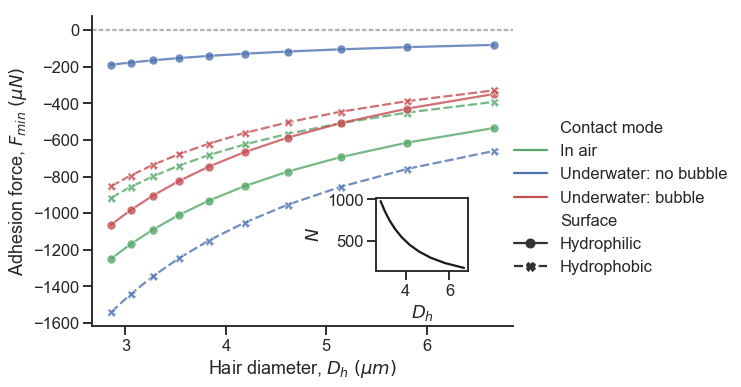

In [56]:
#Effect of hair diameter (self-similar scaling)

#Get model data

# alpha = 0.1
# asp_ratio = 10 #L/Dh

# y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
# y_fw = 2 #fluid-water interfacial tension (N/m)
# y_wa = 3 #water surface tension (N/m)
# phi_f = 2 #fluid size parameter
# phi_b = 1.6 #bubble size parameter

# s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

Dp_Dh_array = np.linspace(30,70,10)
# Dp = 200

modelData = pd.DataFrame()
hairnumData = pd.DataFrame()

for Dp_Dh in Dp_Dh_array:
    Dh = D_p/Dp_Dh 
    s_f = Dh/(2*phi_f) #fluid size scale Vf = 4/3*pi*s_f^3
    
    #Hydrophilic
    theta_fa = 6 #fluid-substrate contact angle in air
    theta_wa = 20 #water-substrate contact angle in air
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                  theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_phil = pd.DataFrame({'Force_air': [Fa],
                            'Force_with_bubble': [Fb],
                            'Force_water': [Fw],
                            'Force_bubble_only': [Fbo],
                            'Hair_dia': [Dh]})
    df_phil['Surface'] = 'Hydrophilic'
    df_phil['theta_fa'] = theta_fa
    df_phil['theta_wa'] = theta_wa
    
    #Hydrophobic
    theta_fa = 56 #fluid-substrate contact angle in air
    theta_wa = 93 #water-substrate contact angle in air
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                  theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_phob = pd.DataFrame({'Force_air': [Fa],
                            'Force_with_bubble': [Fb],
                            'Force_water': [Fw],
                            'Force_bubble_only': [Fbo],
                            'Hair_dia': [Dh]})
    df_phob['Surface'] = 'Hydrophobic'
    df_phob['theta_fa'] = theta_fa
    df_phob['theta_wa'] = theta_wa
    
    df_all = df_phil.append(df_phob)
    
    modelData = modelData.append(df_all)
    
    #number of hairs
    N = alpha*(Dp_Dh**2)
    hairnum_temp = pd.DataFrame({'Hair_dia': [Dh],
                                'Number_of_hairs': [N]})
    hairnumData = hairnumData.append(hairnum_temp)
    
print('contact area:', N*0.25*np.pi*Dh*Dh*1e12, 'um^2')
print('expt avg. contact area in air:', 7724.5, 'um^2')

# Data clean
modelData.rename(columns = {'Force_air': 'In air',
                            'Force_with_bubble': 'Underwater: bubble',
                            'Force_water': 'Underwater: no bubble',
                            'Force_bubble_only': 'Bubble only'},
                 inplace = True)

#forces to include in plot (used to convert data to long form)
force_order = ['In air','Underwater: no bubble','Underwater: bubble']#, 'Bubble only']


column_list = list(modelData.columns)
#reshape force data into long form based on force_order
id_vars_list = [x for x in column_list if x not in force_order]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Contact mode",
                        value_name="Force")


data_reshaped['Force'] = data_reshaped['Force']/1e-6 #uN
data_reshaped['Hair_dia'] = data_reshaped['Hair_dia']/1e-6 #um
hairnumData['Hair_dia'] = hairnumData['Hair_dia']/1e-6 #um

# Configure plot style
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (7.5,6) #figure size

# Plot data
color_list = ['g', 'b', 'r']#, 'r'] #corresponding colors
line_styles = [(1, 0), (1, 0), (1, 0), (1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_reshaped,
                 x = "Hair_dia",
                 y = "Force",
                 hue = "Contact mode",
                 hue_order = force_order,
                 style = "Surface",
                 style_order = ['Hydrophilic','Hydrophobic'],
                 palette= color_list,
                 kind = 'line',
                 markers = True,
                 #dashes = line_styles,
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels(r'Hair diameter, $D_h$ $(\mu m)$', 
                      r"Adhesion force, $F_{min}$ $(\mu N)$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
# for ax1 in ax.axes.flatten():
#     ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
    
#legend adjust
col_num = 1 #number of legend columns SET
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = col_num,
                 framealpha = 0)

        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds

bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 7 #legend location SET


#inset plot: Number of hairs
l, b, h, w = .7, .33, .17, .17
ax2 = fig.add_axes([l, b, w, h])
ax2.plot(hairnumData['Hair_dia'], hairnumData['Number_of_hairs'], 'k')
ax2.set_xlabel(r'$D_h$')
ax2.set_ylabel(r"$N$")


#format plot
ax.fig.set_size_inches(*fig_size)


plt.show()

In [ ]:
#save plot
plot_name = "Figure6-Model_effect_of_hair_size"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

In [57]:
#ladybug's parameter values
N_h = 500 #number of hairs
D_h = 4e-6 #hair diameter (m)
D_p = 200e-6 #pad diameter (m)
L_h = 40e-6 #hair length (m)
y_fa = 27e-3 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 55e-3 #fluid-water interfacial tension (N/m)
y_wa = 72e-3 #water surface tension (N/m)
V_f = 4e-18 #fluid volume (m^3)
# V_b = 1e-12 #bubble volume (m^3)

#convert to model parameters
s_f = (3*V_f/(4*np.pi))**(1/3) #s_f
# s_b = (3*V_b/(4*np.pi))**(1/3) #s_b
phi_f = round(D_h/(2*s_f),1) #D_h/2s_f
# phi_b = round(D_p/(2*s_b),1) #D_p/2s_b
Dp_Dh = D_p/D_h
alpha = N_h/(Dp_Dh**2)
asp_ratio = L_h/D_h
print('Dp_Dh:', Dp_Dh, 'alpha:', alpha, 'asp_ratio:', asp_ratio, 
      'y_fa:', y_fa, 'y_fw:', y_fw, 'y_wa:', y_wa,
      'phi_f', phi_f, 's_f', s_f)

Dp_Dh: 50.00000000000001 alpha: 0.19999999999999993 asp_ratio: 10.000000000000002 y_fa: 0.027 y_fw: 0.055 y_wa: 0.072 phi_f 2.0 s_f 9.847450218426974e-07


137.89550377387408 500.0
137.89550377387408 500.0
137.89550377387408 500.0
137.89550377387408 500.0
137.89550377387408 500.0
137.89550377387408 500.0
137.89550377387408 500.0
69.9386943715081 500.0
69.9386943715081 500.0
69.9386943715081 500.0
69.9386943715081 500.0
69.9386943715081 500.0
69.9386943715081 500.0
69.9386943715081 500.0


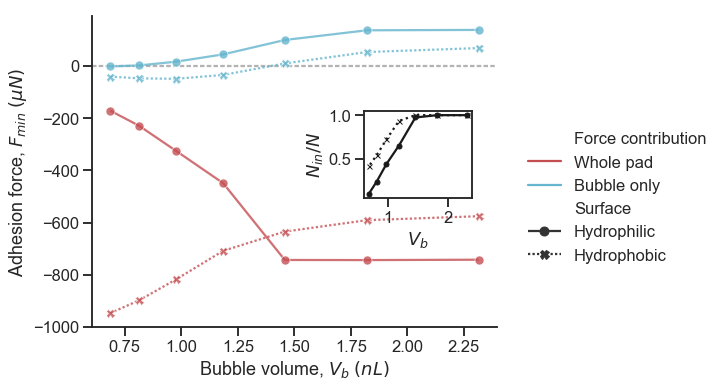

In [58]:
#Effect of bubble volume

# Get model data

# Dp_Dh = 50 #Dp/Dh
# alpha = 0.1
# asp_ratio = 10 #L/Dh

# y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
# y_fw = 2 #fluid-water interfacial tension (N/m)
# y_wa = 3 #water surface tension (N/m)
# phi_f = 2 #fluid size parameter

# s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

df_phil = pd.DataFrame()
F_bubble = []
F_bubble_only = []
volume_bubble = []
phi_b_list = [1.2,1.3,1.4,1.5,1.6,1.7,1.8] 
for phi_b in phi_b_list:
    df_all = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                          theta_fa, theta_wa, phi_f, phi_b, s_f)
    s_b = (phi_f/phi_b)*Dp_Dh*s_f
    df_temp = pd.DataFrame({'F_bubble': [min(df_all['Force_with_bubble'])],
                           'F_bubble_only': [min(df_all['Force_bubble_only'])],
                           'volume_bubble': [(4/3)*np.pi*(s_b**3)],
                           'phi_b':phi_b,
                           'Area_fraction_inside': [min(df_all['Area_fraction_inside'])]})
    df_phil = df_phil.append(df_temp)

df_phil['Surface'] = 'Hydrophilic'
df_phil['theta_fa'] = theta_fa
df_phil['theta_wa'] = theta_wa

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

df_phob = pd.DataFrame()
F_bubble = []
F_bubble_only = []
volume_bubble = []
phi_b_list = [1.2,1.3,1.4,1.5,1.6,1.7,1.8] 
for phi_b in phi_b_list:
    df_all = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                          theta_fa, theta_wa, phi_f, phi_b, s_f)
    s_b = (phi_f/phi_b)*Dp_Dh*s_f
    df_temp = pd.DataFrame({'F_bubble': [min(df_all['Force_with_bubble'])],
                           'F_bubble_only': [min(df_all['Force_bubble_only'])],
                           'volume_bubble': [(4/3)*np.pi*(s_b**3)],
                           'phi_b':phi_b,
                           'Area_fraction_inside': [min(df_all['Area_fraction_inside'])]})
    df_phob = df_phob.append(df_temp)

df_phob['Surface'] = 'Hydrophobic'
df_phob['theta_fa'] = theta_fa
df_phob['theta_wa'] = theta_wa

modelData = df_phil.append(df_phob)

# Data clean
modelData.rename(columns = {'F_bubble': 'Whole pad',
                            'F_bubble_only': 'Bubble only'},
                 inplace = True)

#forces to include in plot (used to convert data to long form)
force_order = ['Whole pad', 'Bubble only']


column_list = list(modelData.columns)
#reshape force data into long form based on force_order
id_vars_list = [x for x in column_list if x not in force_order]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Force contribution",
                        value_name="Force")


data_reshaped['Force'] = data_reshaped['Force']/1e-6 #uN
data_reshaped['volume_bubble'] = data_reshaped['volume_bubble']/1e-12 #nL
df_phil['volume_bubble'] = df_phil['volume_bubble']/1e-12 #nL
df_phob['volume_bubble'] = df_phob['volume_bubble']/1e-12 #nL

# Configure plot style
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (7.5,6) #figure size

# Plot data
color_list = ['r', 'c'] #corresponding colors
line_styles = [(1, 0),(1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_reshaped,
                 x = "volume_bubble",
                 y = "Force",
                 hue = "Force contribution",
                 hue_order = force_order,
                 style = "Surface",
                 style_order = ['Hydrophilic','Hydrophobic'],
                 palette= color_list,
                 kind = 'line',
                 markers = True,
                 dashes = line_styles,
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels(r'Bubble volume, $V_b$ $(nL)$', 
                      r"Adhesion force, $F_{min}$ $(\mu N)$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
# for ax1 in ax.axes.flatten():
#     ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
    
#legend adjust
col_num = 1 #number of legend columns SET
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = col_num,
                 framealpha = 0)

        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds

bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 7 #legend location SET

#inset plot: Fraction of hairs inside bubble
l, b, h, w = .7, .5, .2, .2
ax2 = fig.add_axes([l, b, w, h])
ax2.plot(df_phil['volume_bubble'], df_phil['Area_fraction_inside'], '-ok', markersize=5)
ax2.plot(df_phob['volume_bubble'], df_phob['Area_fraction_inside'], ':xk', markersize=5)
ax2.set_xlabel(r'$V_b$')
ax2.set_ylabel(r"$N_{in}/N$")
# ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

#format plot
ax.fig.set_size_inches(*fig_size)


plt.show()

In [ ]:
#save plot
plot_name = "Figure7-Model_effect_of_bubble_volume"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

In [27]:
#ladybug's case
N_h = 500 #number of hairs
D_h = 4e-6 #hair diameter (m)
D_p = 200e-6 #pad diameter (m)
L_h = 40e-6 #hair length (m)
y_fa = 27e-3 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 55e-3 #fluid-water interfacial tension (N/m)
y_wa = 72e-3 #water surface tension (N/m)
V_f = 4e-18 #fluid volume (m^3)
V_b = 1e-12 #bubble volume (m^3)


s_f = (3*V_f/(4*np.pi))**(1/3) #s_f
s_b = (3*V_b/(4*np.pi))**(1/3) #s_b
phi_f = round(D_h/(2*s_f),1) #D_h/2s_f
phi_b = round(D_p/(2*s_b),1) #D_p/2s_b

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
cos_fw = -1 if cos_fw <-1 else cos_fw
cos_fw = 1 if cos_fw >1 else cos_fw
theta_fw = np.arccos(cos_fw)*180/np.pi 
print(theta_fw)

fr_fit = fit_dict[phi_f][0]
F_phil_a = np.polyval(fr_fit,theta_fa)*y_fa*s_f*N_h
F_phil_w = np.polyval(fr_fit,theta_fw)*y_fw*s_f*N_h
print(F_phil_a/1e-6, F_phil_w/1e-6)

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 90 #water-substrate contact angle in air

cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
cos_fw = -1 if cos_fw <-1 else cos_fw
cos_fw = 1 if cos_fw >1 else cos_fw
theta_fw = np.arccos(cos_fw)*180/np.pi 
print(theta_fw)

fr_fit = fit_dict[phi_f][0]
F_phob_a = np.polyval(fr_fit,theta_fa)*y_fa*s_f*N_h
F_phob_w = np.polyval(fr_fit,theta_fw)*y_fw*s_f*N_h
print(F_phob_a/1e-6, F_phob_w/1e-6)

137.89550377387408
-878.5526906586565 -133.16619553731434
74.06701290401661
-644.0870827596619 -1014.325483038178


Water/Air Slope: 3.607370812320516e-16 R2: 0.01329670329670335
Bubble/Air Slope: -1.2544358486218654 R2: 0.7910366312114728


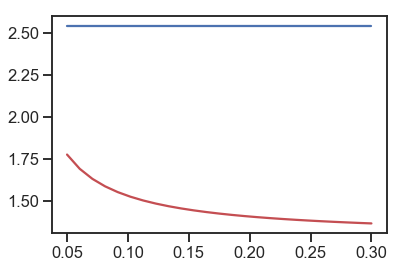

In [19]:
#sensitivity analysis: alpha

# alpha = 0.1
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

# theta_fa = 6#6 #fluid-substrate contact angle in air
# theta_wa = 24#20 #water-substrate contact angle in air

theta_fa = 50#56 #fluid-substrate contact angle in air
theta_wa = 120#90 #water-substrate contact angle in air

alpha_array = np.linspace(0.05,0.3,25)
df = pd.DataFrame()
Fa_array = []
Fw_array = []
Fb_array = []
Fbo_array = []
for alpha in alpha_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'alpha': [alpha],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['alpha'], df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['alpha'], df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)

#plots
# plt.plot(df['alpha'], df['Force_air'], '-g')
# plt.plot(df['alpha'], df['Force_water'], '-b')
# plt.plot(df['alpha'], df['Force_bubble'], '-r')

plt.plot(df['alpha'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['alpha'], df['Force_bubble']/df['Force_air'], '-r')

plt.show()

Water/Air Slope: 0.0 R2: 0.0
Bubble/Air Slope: 0.11733763188311797 R2: 0.9649812814219829


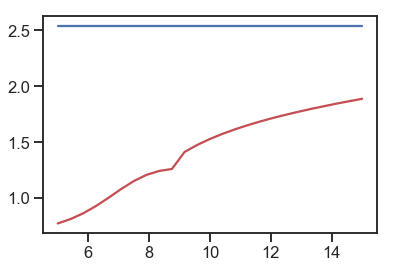

In [20]:
#sensitivity analysis: asp_ratio

alpha = 0.1
# asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

# theta_fa = 6#6 #fluid-substrate contact angle in air
# theta_wa = 24#20 #water-substrate contact angle in air

theta_fa = 50#56 #fluid-substrate contact angle in air
theta_wa = 120#90 #water-substrate contact angle in air

asp_ratio_array = np.linspace(5,15,25)
df = pd.DataFrame()
Fa_array = []
Fw_array = []
Fb_array = []
Fbo_array = []
for asp_ratio in asp_ratio_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Aspect_ratio': [asp_ratio],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Aspect_ratio'], df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Aspect_ratio'], df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)

#plots
# plt.plot(df['Aspect_ratio'], df['Force_air'], '-g')
# plt.plot(df['Aspect_ratio'], df['Force_water'], '-b')
# plt.plot(df['Aspect_ratio'], df['Force_bubble'], '-r')

plt.plot(df['Aspect_ratio'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Aspect_ratio'], df['Force_bubble']/df['Force_air'], '-r')

plt.show()

Water/Air Slope: 0.0217779974633899 R2: 0.2621117337861375
Bubble/Air Slope: 0.08590031692336923 R2: 0.993925228572242


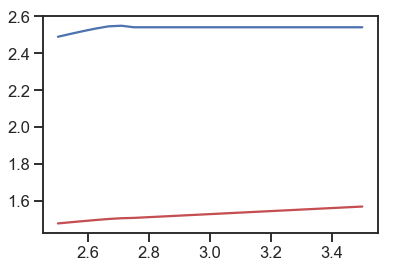

In [21]:
#sensitivity analysis: y_wa

alpha = 0.1
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
# y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

# theta_fa = 6#6 #fluid-substrate contact angle in air
# theta_wa = 24#20 #water-substrate contact angle in air

theta_fa = 50#56 #fluid-substrate contact angle in air
theta_wa = 120#90 #water-substrate contact angle in air

y_wa_array = np.linspace(2.5,3.5,25)
df = pd.DataFrame()
Fa_array = []
Fw_array = []
Fb_array = []
Fbo_array = []
for y_wa in y_wa_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Water-air_interfacial_tension': [y_wa],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Water-air_interfacial_tension'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Water-air_interfacial_tension'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)

#plots
# plt.plot(df['Aspect_ratio'], df['Force_air'], '-g')
# plt.plot(df['Aspect_ratio'], df['Force_water'], '-b')
# plt.plot(df['Aspect_ratio'], df['Force_bubble'], '-r')

plt.plot(df['Water-air_interfacial_tension'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Water-air_interfacial_tension'], df['Force_bubble']/df['Force_air'], '-r')

plt.show()

Water/Air Slope: 1.0836986397693065 R2: 0.9791053747524961
Bubble/Air Slope: 0.19916884027720566 R2: 0.9791053747524955


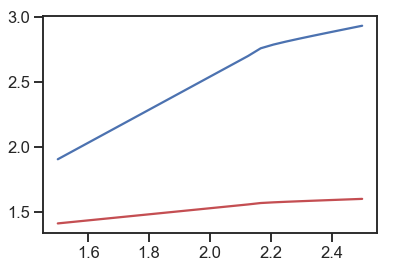

In [22]:
#sensitivity analysis: y_fw

alpha = 0.1
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
# y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

# theta_fa = 6#6 #fluid-substrate contact angle in air
# theta_wa = 24#20 #water-substrate contact angle in air

theta_fa = 50#56 #fluid-substrate contact angle in air
theta_wa = 120#90 #water-substrate contact angle in air

y_fw_array = np.linspace(1.5,2.5,25)
df = pd.DataFrame()
Fa_array = []
Fw_array = []
Fb_array = []
Fbo_array = []
for y_fw in y_fw_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Fluid-water_interfacial_tension': [y_fw],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Fluid-water_interfacial_tension'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Fluid-water_interfacial_tension'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)

#plots
# plt.plot(df['Aspect_ratio'], df['Force_air'], '-g')
# plt.plot(df['Aspect_ratio'], df['Force_water'], '-b')
# plt.plot(df['Aspect_ratio'], df['Force_bubble'], '-r')

plt.plot(df['Fluid-water_interfacial_tension'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Fluid-water_interfacial_tension'], df['Force_bubble']/df['Force_air'], '-r')

plt.show()

Water/Air Slope: -0.3022536170069738 R2: 0.900155825623926
Bubble/Air Slope: -0.5128799376845593 R2: 0.9811252233027586


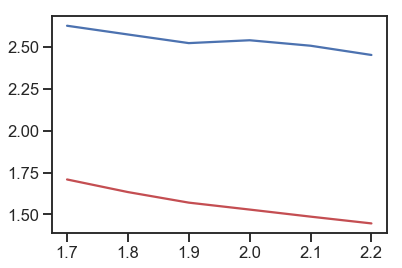

In [23]:
#sensitivity analysis: phi_f

alpha = 0.1
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
# phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

# theta_fa = 6#6 #fluid-substrate contact angle in air
# theta_wa = 24#20 #water-substrate contact angle in air

theta_fa = 50#56 #fluid-substrate contact angle in air
theta_wa = 120#90 #water-substrate contact angle in air

phi_f_array = [1.7, 1.8, 1.9, 2, 2.1, 2.2] #INCLUDE MORE!
df = pd.DataFrame()
Fa_array = []
Fw_array = []
Fb_array = []
Fbo_array = []
for phi_f in phi_f_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Fluid_size_param': [phi_f],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Fluid_size_param'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Fluid_size_param'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)

#plots
# plt.plot(df['Aspect_ratio'], df['Force_air'], '-g')
# plt.plot(df['Aspect_ratio'], df['Force_water'], '-b')
# plt.plot(df['Aspect_ratio'], df['Force_bubble'], '-r')

plt.plot(df['Fluid_size_param'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Fluid_size_param'], df['Force_bubble']/df['Force_air'], '-r')

plt.show()

Water/Air Slope: 0.0 R2: 0.0
Bubble/Air Slope: 1.7881348842632823 R2: 0.967687757243261


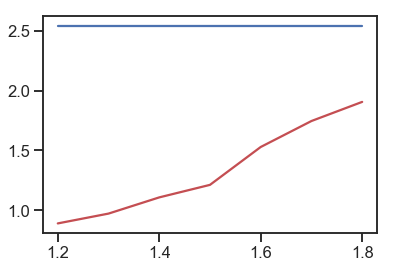

In [24]:
#sensitivity analysis: phi_b

alpha = 0.1
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
# phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

# theta_fa = 6#6 #fluid-substrate contact angle in air
# theta_wa = 24#20 #water-substrate contact angle in air

theta_fa = 50#56 #fluid-substrate contact angle in air
theta_wa = 120#90 #water-substrate contact angle in air

phi_b_array = [1.2,1.3,1.4,1.5,1.6,1.7,1.8] #INCLUDE MORE!
df = pd.DataFrame()
Fa_array = []
Fw_array = []
Fb_array = []
Fbo_array = []
for phi_b in phi_b_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Bubble_size_param': [phi_b],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Bubble_size_param'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Bubble_size_param'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)

#plots
# plt.plot(df['Aspect_ratio'], df['Force_air'], '-g')
# plt.plot(df['Aspect_ratio'], df['Force_water'], '-b')
# plt.plot(df['Aspect_ratio'], df['Force_bubble'], '-r')

plt.plot(df['Bubble_size_param'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Bubble_size_param'], df['Force_bubble']/df['Force_air'], '-r')

plt.show()